In [2]:
import os
import json
import numpy as np
from skimage.draw import disk
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
from sklearn.model_selection import LeaveOneOut
import tensorflow as tf

def create_mask_from_json(json_data, shape):
    mask = np.zeros(shape, dtype=np.float32)
    for item in json_data:
        rr, cc = disk((item['y'], item['x']), item['radius'], shape=shape)
        mask[rr, cc] = 1.0
    return mask

def resize_labels(labels, original_size, new_size):
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels

def load_images_and_labels(image_paths, label_dir, new_size):
    original_size = (1024, 1024)  # Original size of the images and labels
    images = []
    masks = []

    for image_path in image_paths:
        # Extract filename without extension to match with the label
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        label_file = os.path.join(label_dir, base_filename + '.json')

        # Load and resize image
        image = img_to_array(load_img(image_path, color_mode='rgb', target_size=new_size))
        images.append(image / 255.0)  # Normalizing to [0, 1]

        # Load and resize corresponding label
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size, new_size)
        mask = create_mask_from_json(resized_json_data, shape=new_size)
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, *new_size, 1)



def create_loocv_folds(image_files, augmented_image_dir):
    folds = []
    n = len(image_files)

    for i in range(n):
        test_image = image_files[i]
        
        # Ensure validation images are different from the test image and rotate them
        val_indices = [(i + 1) % n, (i + 2) % n]
        validation_images = [image_files[j] for j in val_indices]

        # Remaining images for training, excluding the test and validation images
        train_images = [img for idx, img in enumerate(image_files) if idx not in [i, val_indices[0], val_indices[1]]]

        # Augmented images for training
        augmented_train_images = [os.path.join(augmented_image_dir, os.path.basename(img).replace('.png', f'_aug_{k}.png')) 
                                  for img in train_images for k in range(20)]

        folds.append((augmented_train_images, [test_image], validation_images))

    return folds



In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation


def create_deeplabv3_plus_binary_model(input_shape=(512, 512, 3), l2_lambda=0.01, fine_tune_at=200):
    # Load MobileNetV2 pre-trained on ImageNet as the backbone
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Unfreeze the top layers of the model for fine-tuning
    backbone.trainable = True
    for layer in backbone.layers[:fine_tune_at]:
        layer.trainable = False

    # Use features from the backbone network - feature extraction
    x = backbone.output

    # Apply atrous convolutions / spatial pyramid pooling
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)

    # Atrous Spatial Pyramid Pooling (ASPP)
    b0 = layers.Conv2D(256, (1, 1), activation='relu', padding='same', dilation_rate=1, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=6, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    b2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=12, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    b3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=18, kernel_regularizer=regularizers.l2(l2_lambda))(x)

    # Concatenate the atrous and image-level features
    x = layers.Concatenate()([b0, b1, b2, b3])

    # Add a convolutional layer on top of the concatenated features
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    # Start with a simple 1x1 convolution
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)

    # Perform upsampling in steps to reach the output size of 512x512.
    # Each UpSampling2D layer doubles the size of the feature map
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 32x32
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 64x64
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 128x128
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 256x256
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 512x512

    # Output layer for binary segmentation
    output = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=backbone.input, outputs=output)

    return model

# Create the model
model = create_deeplabv3_plus_binary_model()

# Compile the model (if you're about to train it)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to verify the architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 256, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 256, 256, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 256, 256, 32)         0         ['bn_Conv1[0][0]']        

In [4]:
def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
    # A conv block consists of two convolutions, each followed by a batch normalization and a relu activation.
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(512, 512, 3), num_filters=16, depth=2, dropout=0.5, batch_norm=True):
    # INPUT LAYER
    inputs = Input(input_size)
    # CONTRACTING PATH
    conv_blocks = []
    x = inputs
    for i in range(depth):
        x = conv_block(x, num_filters * (2**i), do_batch_norm=batch_norm)
        conv_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout)(x)

    # BOTTLENECK
    x = conv_block(x, num_filters * (2**(depth)), do_batch_norm=batch_norm)
    
    # EXPANSIVE PATH
    for i in reversed(range(depth)):
        num_filters_exp = num_filters * (2**i)
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, conv_blocks[i]], axis=3)
        x = conv_block(x, num_filters_exp, do_batch_norm=batch_norm)

    # FINAL CONVOLUTION
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [5]:
# Create the model
model = unet()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 512, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 512, 512, 16)         64        ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization_2[

In [74]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import os

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 0:
        return lr
    elif epoch < 15 and epoch%2 == 0:
        return lr * tf.math.exp(-0.2)
    elif epoch > 30:
        return lr * tf.math.exp(-0.5)
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

log_dir = "./tensorboard_logs"

def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        return K.mean(weighted_bce)
    return loss

def train_unet(model, train_images, train_masks, val_images, val_masks, epochs=300, batch_size=32, checkpoint_path='pixel_cores.hdf5'):
    # Define the custom loss function
    custom_loss = weighted_binary_crossentropy(zero_weight=1, one_weight=1)

    # Check if a previous checkpoint exists
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from checkpoint: {checkpoint_path}")
        # Load the model with the custom loss function
        model = load_model(checkpoint_path, custom_objects={'loss': custom_loss})
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Compile the model with the custom loss function
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss, metrics=['AUC', 'accuracy', 'Precision', 'Recall'])
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
    
    # Define the TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)

    # Fit the model with the given training and validation data
    history = model.fit(
        x=train_images, 
        y=train_masks, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1, 
        validation_data=(val_images, val_masks), 
        callbacks=[model_checkpoint, tensorboard_callback, lr_scheduler, early_stopping]
    )
    
    return model



In [7]:
import os
import numpy as np
import csv  # Import the csv module

original_image_dir = './TMA_WSI_Padded_PNGs'
augmented_image_dir = './augmented_images'
original_label_dir = './TMA_WSI_Labels_updated'
augmented_label_dir = './augmented_labels'

# Use list comprehension to create the list of file paths
original_image_files = [os.path.join(original_image_dir, file) for file in sorted(
    os.listdir(original_image_dir)) if file.endswith('.png')]

folds = create_loocv_folds(original_image_files, augmented_image_dir)


In [8]:
import csv

# Define the path to the CSV file
csv_file = 'model_evaluation_results.csv'

# Open the CSV file in append mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Fold', 'Loss', 'AUC', 'Accuracy', 'Precision', 'Recall'])

    # Iterate over each fold
    for i, fold in enumerate(folds):
        # Load the checkpointed model for the fold
        model_path = f"pixel_core_fold_{i+1}.hdf5"
        loaded_model = tf.keras.models.load_model(model_path, custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

        # Unpack the fold
        train_image, test_image, val_images = fold

        # Load the test images and masks
        test_images, test_masks = load_images_and_labels(test_image, original_label_dir, (512,512))

        # Evaluate the model on the test set
        loss, auc, accuracy, precision, recall = loaded_model.evaluate(test_images, test_masks)

        # Write the evaluation metrics to the CSV file
        writer.writerow([i+1, loss, auc, accuracy, precision, recall])
    

        # Flush the changes to the CSV file
        file.flush()


1/1 [==============================] - 0s 235ms/step - loss: 0.1044 - auc: 0.9940 - accuracy: 0.9804 - precision: 0.8230 - recall: 0.9236


In [46]:

# Evaluation metrics initialization
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

new_size = (512, 512)

# Open a CSV file to write the results
with open('model_evaluation_results.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    # Check if the file is empty by seeking to the end and getting the position
    file.seek(0, os.SEEK_END)
    if file.tell() == 0:
        # File is empty, write the header
        writer.writerow(['Fold', 'Loss', 'AUC', 'Accuracy', 'Precision', 'Recall'])

    file.flush() 
    indices = [14,16,19]
    # Iterate over each fold
    i = 0
    for i, fold in enumerate([folds[index - 1] for index in indices], start=1):
        augmented_train_images, test_image, validation_images = fold
        i = indices[i-1]
        # Load and preprocess images and labels
        train_images, train_masks = load_images_and_labels(
            augmented_train_images, augmented_label_dir, new_size)
        test_images, test_masks = load_images_and_labels(
            test_image, original_label_dir, new_size)
        val_images, val_masks = load_images_and_labels(
            validation_images, original_label_dir, new_size)

        # Create a new instance of the model
        model = unet()

        # Train the model
        trained_model = train_unet(model, train_images, train_masks, val_images, val_masks, 150, 32, "pixel_core_fold_{i}.hdf5".format(i=i))

        # Evaluate the model on the test set
        loss, auc, accuracy, precision, recall = trained_model.evaluate(
            test_images, test_masks)

        # Store the evaluation metrics
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # Write the fold results to the CSV file
        writer.writerow([i, loss, auc, accuracy, precision, recall])
        file.flush() 

Loading weights from checkpoint: pixel_core_fold_14.hdf5
Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 0.2560 - auc: 0.9751 - accuracy: 0.9449 - precision: 0.8600 - recall: 0.8846 
Epoch 1: val_loss improved from inf to 0.55685, saving model to pixel_core_fold_14.hdf5
10/10 [==============================] - 115s 11s/step - loss: 0.2560 - auc: 0.9751 - accuracy: 0.9449 - precision: 0.8600 - recall: 0.8846 - val_loss: 0.5568 - val_auc: 0.7613 - val_accuracy: 0.8361 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 3.0327e-04
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: 0.2361 - auc: 0.9745 - accuracy: 0.9473 - precision: 0.8766 - recall: 0.8750 
Epoch 2: val_loss improved from 0.55685 to 0.51113, saving model to pixel_core_fold_14.hdf5
10/10 [==============================] - 111s 11s/step - loss: 0.2361 - auc: 0.9745 - accuracy: 0.9473 - precision: 0.8766 - recall: 0.8750 - val_loss: 0.5111 - val_auc: 0.4037 - val_accuracy: 0.8361

In [40]:
import pandas as pd

results = pd.read_csv('model_evaluation_results.csv') 

results.describe()

,Fold,Loss,AUC,Accuracy,Precision,Recall
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,10.000000,0.173526,0.979902,0.944278,0.857093,0.878364
std,5.627314,0.057366,0.016022,0.021369,0.081105,0.092810
min,1.000000,0.089000,0.934922,0.891060,0.703799,0.668352
25%,5.500000,0.134935,0.977651,0.931433,0.801033,0.823237
50%,10.000000,0.153797,0.985674,0.948444,0.877027,0.920812
75%,14.500000,0.203283,0.989798,0.956776,0.911463,0.930040
max,19.000000,0.306458,0.993985,0.980431,0.980146,0.989105


1/1 [==============================] - 0s 196ms/step


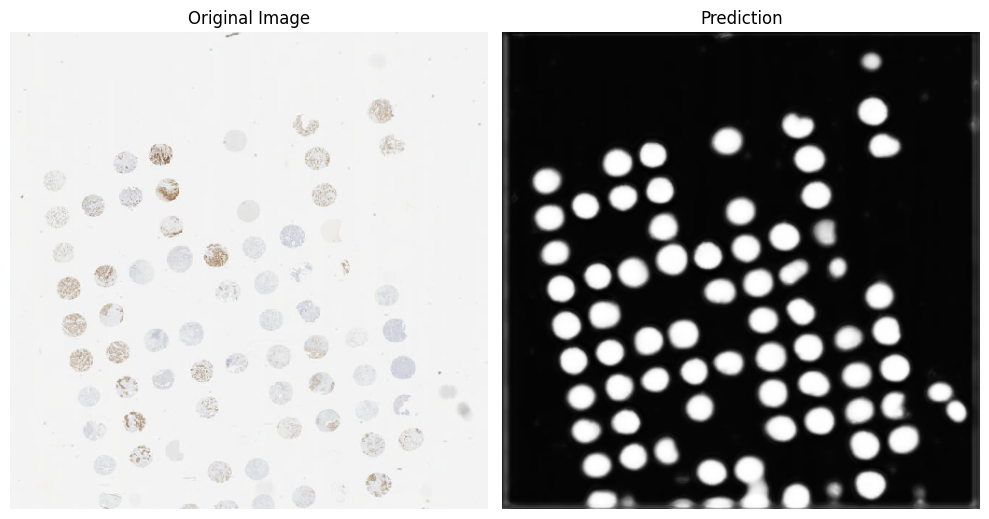

In [48]:
import matplotlib.pyplot as plt 
def plot_predictions_for_fold(model, fold_index, test_images, test_masks):
    # Make predictions on the test set
    predictions = model.predict(test_images)

    # Plot the original images and their corresponding predictions
    fig, axes = plt.subplots(len(test_images), 2, figsize=(10, 10))
    for i, (image, mask, prediction) in enumerate(zip(test_images, test_masks, predictions)):
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(prediction.squeeze(), cmap='gray')
        axes[1].set_title('Prediction')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming the create_loocv_folds function returns a list of folds
folds = create_loocv_folds(original_image_files, augmented_image_dir)

# Assuming the 10th fold is at index 9
fold_index = 12

# Assuming the 10th fold contains test images and masks
test_images = folds[fold_index][1]

test_image, test_mask = load_images_and_labels(test_images, original_label_dir, (512,512))

# Assuming the 10th fold model is stored in a variable called "model_10"
model_10 = tf.keras.models.load_model("pixel_core_fold_10.hdf5", custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

# Plot the predictions for the 10th fold
plot_predictions_for_fold(model_10, fold_index, test_image, test_masks)


In [76]:
# Assuming the create_loocv_folds function returns a list of folds
folds = create_loocv_folds(original_image_files, augmented_image_dir)

# Get the augmented training images and validation images
augmented_train_images = folds[0][0]
validation_images = folds[0][2]

augmented_test_images = []
for image_path in folds[0][1]:
    for i in range(20):
        augmented_image_path = os.path.join(augmented_image_dir, f"{os.path.basename(image_path).split('.')[0]}_aug_{i}.png")
        augmented_test_images.append(augmented_image_path)

augmented_train_images.extend(augmented_test_images)


# # Load and preprocess the augmented training images and validation images
train_images, train_masks = load_images_and_labels(augmented_train_images, augmented_label_dir, (512, 512))
val_images, val_masks = load_images_and_labels(validation_images, original_label_dir, (512, 512))

# Create a new instance of the model
model = load_model("pixel_core_fold_1.hdf5", custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

# Train the model
trained_model = train_unet(model, train_images, train_masks, val_images, val_masks, 150, 32, "final_segmentation_model.hdf5".format(i=i))


No checkpoint found. Starting training from scratch.
Epoch 1/150
11/11 [==============================] - ETA: 0s - loss: 0.1016 - auc: 0.9898 - accuracy: 0.9619 - precision: 0.9167 - recall: 0.8796 
Epoch 1: val_loss improved from inf to 0.13260, saving model to final_segmentation_model.hdf5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 123s 11s/step - loss: 0.1016 - auc: 0.9898 - accuracy: 0.9619 - precision: 0.9167 - recall: 0.8796 - val_loss: 0.1326 - val_auc: 0.9878 - val_accuracy: 0.9475 - val_precision: 0.9037 - val_recall: 0.9293 - lr: 8.1873e-04
Epoch 2/150
11/11 [==============================] - ETA: 0s - loss: 0.0969 - auc: 0.9908 - accuracy: 0.9633 - precision: 0.9177 - recall: 0.8865 
Epoch 2: val_loss did not improve from 0.13260
11/11 [==============================] - 116s 11s/step - loss: 0.0969 - auc: 0.9908 - accuracy: 0.9633 - precision: 0.9177 - recall: 0.8865 - val_loss: 0.1797 - val_auc: 0.9793 - val_accuracy: 0.9259 - val_precision: 0.9009 - val_recall: 0.8543 - lr: 8.1873e-04
Epoch 3/150
11/11 [==============================] - ETA: 0s - loss: 0.0954 - auc: 0.9910 - accuracy: 0.9637 - precision: 0.9147 - recall: 0.8924 
Epoch 3: val_loss did not improve from 0.13260
11/11 [==============================] - 114s 10s/step - loss: 0.0954 - auc: 0.9910 - ac

KeyboardInterrupt: 